<a href="https://colab.research.google.com/github/moridin04/CCDEPLRL_PROJECT_COM222ML/blob/main/emotiondetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import requests
from io import BytesIO
from PIL import Image

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"moridin04","key":"bd18f27313d41d934e958b4e1b59a576"}'}

In [4]:
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!pwd

-rw-r--r-- 1 root root 65 Jun 16 07:35 kaggle.json
/content


In [5]:
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets list

ref                                                             title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
rakeshkapilavai/extrovert-vs-introvert-behavior-data            Extrovert vs. Introvert Behavior Data                    31277  2025-06-13 14:26:48.303000          18227        402  1.0              
bismasajjad/global-ai-job-market-and-salary-trends-2025         Global AI Job Market & Salary Trends 2025               529004  2025-06-01 07:20:49.537000           6613        107  0.9411765        
adilshamim8/social-media-addiction-vs-relationships             Students' Social Media Addiction                          7851  2025-05-10 14:38:02.713000          17531        266  1.0              


In [7]:
!kaggle datasets download -d msambare/fer2013 -p /content/drive/MyDrive/emotiondata

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
  0% 0.00/60.3M [00:00<?, ?B/s]
100% 60.3M/60.3M [00:00<00:00, 970MB/s]


In [8]:
!unzip /content/drive/MyDrive/emotiondata/fer2013.zip -d /content/drive/MyDrive/emotiondata

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/emotiondata/train/sad/Training_65242339.jpg  
  inflating: /content/drive/MyDrive/emotiondata/train/sad/Training_65267116.jpg  
  inflating: /content/drive/MyDrive/emotiondata/train/sad/Training_65275626.jpg  
  inflating: /content/drive/MyDrive/emotiondata/train/sad/Training_6529266.jpg  
  inflating: /content/drive/MyDrive/emotiondata/train/sad/Training_65329617.jpg  
  inflating: /content/drive/MyDrive/emotiondata/train/sad/Training_65338712.jpg  
  inflating: /content/drive/MyDrive/emotiondata/train/sad/Training_65338797.jpg  
  inflating: /content/drive/MyDrive/emotiondata/train/sad/Training_65387162.jpg  
  inflating: /content/drive/MyDrive/emotiondata/train/sad/Training_65404494.jpg  
  inflating: /content/drive/MyDrive/emotiondata/train/sad/Training_65426218.jpg  
  inflating: /content/drive/MyDrive/emotiondata/train/sad/Training_65430136.jpg  
  inflating: /content/drive/MyDrive/emotiondata/

In [9]:
# === Directory paths ===
train_dir = "/content/drive/MyDrive/emotiondata/train"
test_dir = "/content/drive/MyDrive/emotiondata/test"
image_size = (48, 48)
batch_size = 64

In [10]:
!find /content -type d -name "train"

/content/drive/MyDrive/emotiondata/train


In [11]:
# === Data Generators ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 25841 images belonging to 7 classes.
Found 2868 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [12]:
# === Class Info ===
num_classes = train_generator.num_classes
class_names = list(train_generator.class_indices.keys())

In [13]:
# === Build CNN Model ===
model = models.Sequential([
    layers.Input(shape=(48, 48, 1)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,982,215 (19.01 MB)

 Trainable params: 4,980,935 (19.00 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [14]:
# === Callbacks ===
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
model_checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1)


In [15]:
# === Train ===
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    callbacks=[early_stopping, lr_schedule, model_checkpoint]
)

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


403/404 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.2429 - loss: 2.2412

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.15202, saving model to best_model.keras
404/404 ━━━━━━━━━━━━━━━━━━━━ 44s 78ms/step - accuracy: 0.2431 - loss: 2.2399 - val_accuracy: 0.1520 - val_loss: 10.4485 - learning_rate: 0.0010
Epoch 2/40
403/404 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3762 - loss: 1.6256
Epoch 2: val_accuracy improved from 0.15202 to 0.42190, saving model to best_model.keras
404/404 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - accuracy: 0.3763 - loss: 1.6253 - val_accuracy: 0.4219 - val_loss: 1.5738 - learning_rate: 0.0010
Epoch 3/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4388 - loss: 1.4618
Epoch 3: val_accuracy improved from 0.42190 to 0.45467, saving model to best_model.keras
404/404 ━━━━━━━━━━━━━━━━━━━━ 23s 57ms/step - accuracy: 0.4388 - loss: 1.4617 - val_accuracy: 0.4547 - val_loss: 1.4521 - learning_rate: 0.0010
Epoch 4/40
403/404 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4880 - loss: 1.3613
Epoch 4: val_accuracy did not improve from 0

In [16]:
# === Evaluate ===
loss, acc = model.evaluate(test_generator)
print(f"\n✅ Test Accuracy: {acc:.2f}, Loss: {loss:.4f}")


  4/113 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6429 - loss: 0.9253

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6151 - loss: 1.0399

✅ Test Accuracy: 0.65, Loss: 0.9619


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step

📋 Classification Report:
              precision    recall  f1-score   support

       angry       0.51      0.66      0.58       958
     disgust       0.81      0.31      0.44       111
        fear       0.58      0.31      0.40      1024
       happy       0.86      0.86      0.86      1774
     neutral       0.55      0.70      0.62      1233
         sad       0.52      0.51      0.51      1247
    surprise       0.79      0.75      0.77       831

    accuracy                           0.65      7178
   macro avg       0.66      0.59      0.60      7178
weighted avg       0.65      0.65      0.64      7178



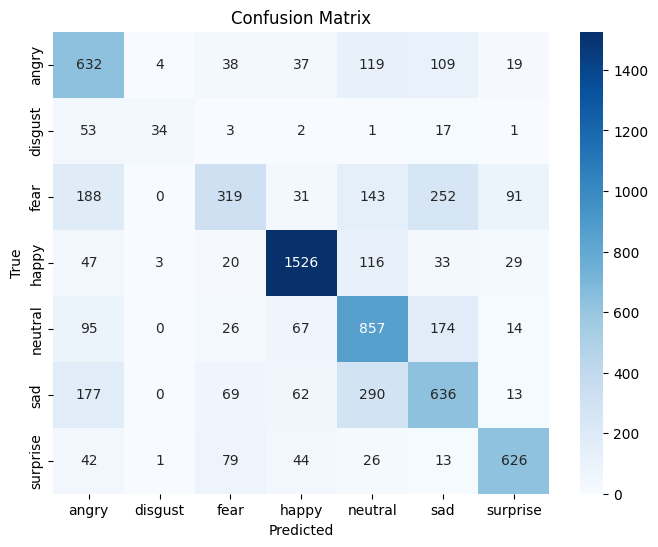

In [17]:
# === Classification Report and Confusion Matrix ===
y_pred_probs = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = test_generator.classes

print("\n📋 Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true_classes, y_pred_classes), annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


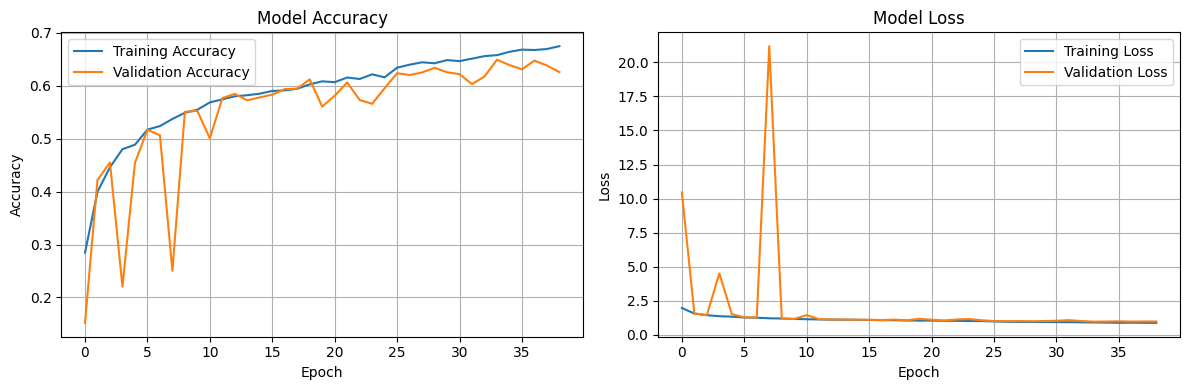

45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step


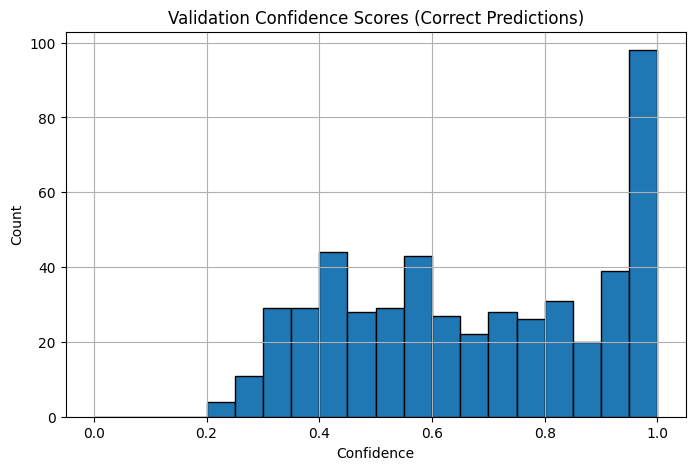


📊 Validation Confidence Statistics (Correct Predictions):
   ➤ Mean Confidence: 0.6778
   ➤ Median Confidence: 0.6768
   ➤ Min Confidence: 0.2171
   ➤ Max Confidence: 0.9998


In [18]:
# === Training History Visualization ===
plt.figure(figsize=(12, 4))

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# === Validation Confidence Scores ===
# Get predictions for validation set
val_pred_probs = model.predict(val_generator)
val_pred_classes = np.argmax(val_pred_probs, axis=1)
val_true_classes = val_generator.classes

# Calculate confidence scores for correct predictions
correct_idx = np.where(val_pred_classes == val_true_classes)[0]
confidences = np.max(val_pred_probs[correct_idx], axis=1)

# Plot confidence distribution
plt.figure(figsize=(8, 5))
plt.hist(confidences, bins=20, range=(0, 1), edgecolor='black')
plt.title('Validation Confidence Scores (Correct Predictions)')
plt.xlabel('Confidence')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Print confidence statistics
print("\n📊 Validation Confidence Statistics (Correct Predictions):")
print(f"   ➤ Mean Confidence: {np.mean(confidences):.4f}")
print(f"   ➤ Median Confidence: {np.median(confidences):.4f}")
print(f"   ➤ Min Confidence: {np.min(confidences):.4f}")
print(f"   ➤ Max Confidence: {np.max(confidences):.4f}")

In [19]:
# === Save Model ===
model.save("emotion_model.keras")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("emotion_model.tflite", "wb") as f:
    f.write(tflite_model)

print("\n✅ Model saved as emotion_model.keras and emotion_model.tflite")


Saved artifact at '/tmp/tmp2c_nrxaw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  136633252348944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136633252352016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136633252352400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136633252352208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136633252352784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136633252351824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136633252350288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136633252353744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136633252353936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136633252349904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136633252353360:

In [20]:
# === GitHub Image Tester ===
def test_image_from_github(url):
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content)).convert('L')
        img_resized = img.resize(image_size)
        img_array = np.array(img_resized).astype(np.float32) / 255.0
        img_input = np.expand_dims(img_array, axis=[0, -1])

        prediction = model.predict(img_input)
        predicted_class = int(np.argmax(prediction))
        confidence = float(np.max(prediction))

        print(f"\n🌐 Prediction from GitHub URL:")
        print(f"   ➤ Emotion: {class_names[predicted_class]} (Confidence: {confidence:.2f})")

        plt.imshow(img_array, cmap='gray')
        plt.title(f"Predicted: {class_names[predicted_class]}")
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"❌ Error loading image: {e}")

# === Example Usage ===
# test_image_from_github("https://raw.githubusercontent.com/mh0386/facial_emotion_dataset/main/dataset/happy/happy1.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


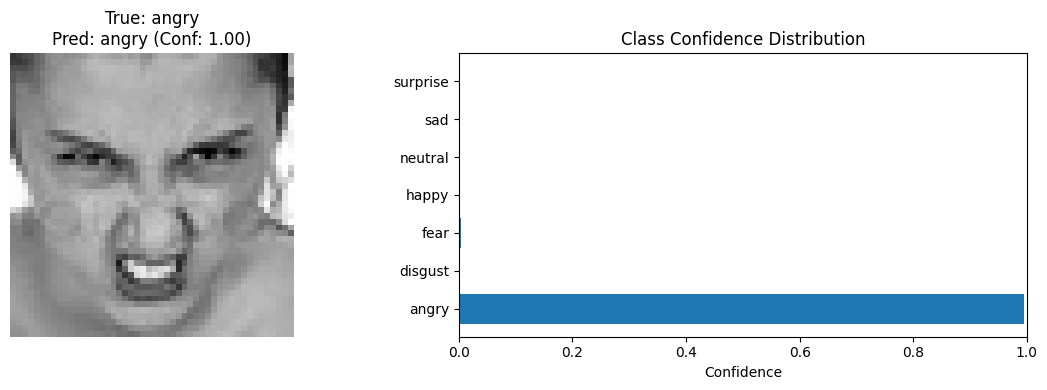

In [27]:
def show_prediction(image, true_label, model, class_names):
    """Show single image prediction with confidence distribution"""
    pred = model.predict(np.expand_dims(image, axis=0))[0]
    pred_class = np.argmax(pred)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_class]} (Conf: {np.max(pred):.2f})")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.barh(class_names, pred)
    plt.xlabel("Confidence")
    plt.xlim([0, 1])
    plt.title("Class Confidence Distribution")

    plt.tight_layout()
    plt.show()

x_test, y_test = next(test_generator)
show_prediction(x_test[0], np.argmax(y_test[0]), model, class_names)

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def predictions(test_generator, model, class_names):
    x_batch, y_batch = next(test_generator)
    y_true = np.argmax(y_batch, axis=1)

    y_pred = model.predict(x_batch)
    y_pred_classes = np.argmax(y_pred, axis=1)
    confidences = np.max(y_pred, axis=1)

    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x_batch[i].squeeze(), cmap='gray')

        if y_pred_classes[i] == y_true[i]:
            text_color = 'green'
        else:
            text_color = 'red'

        plt.title(
            f"True: {class_names[y_true[i]]}\nPred: {class_names[y_pred_classes[i]]}\nConf: {confidences[i]:.2f}",
            color=text_color,
            fontsize=9
        )
        plt.axis('off')

    plt.tight_layout()
    plt.show()


🔍 Sample Predictions (3x3 Grid):
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


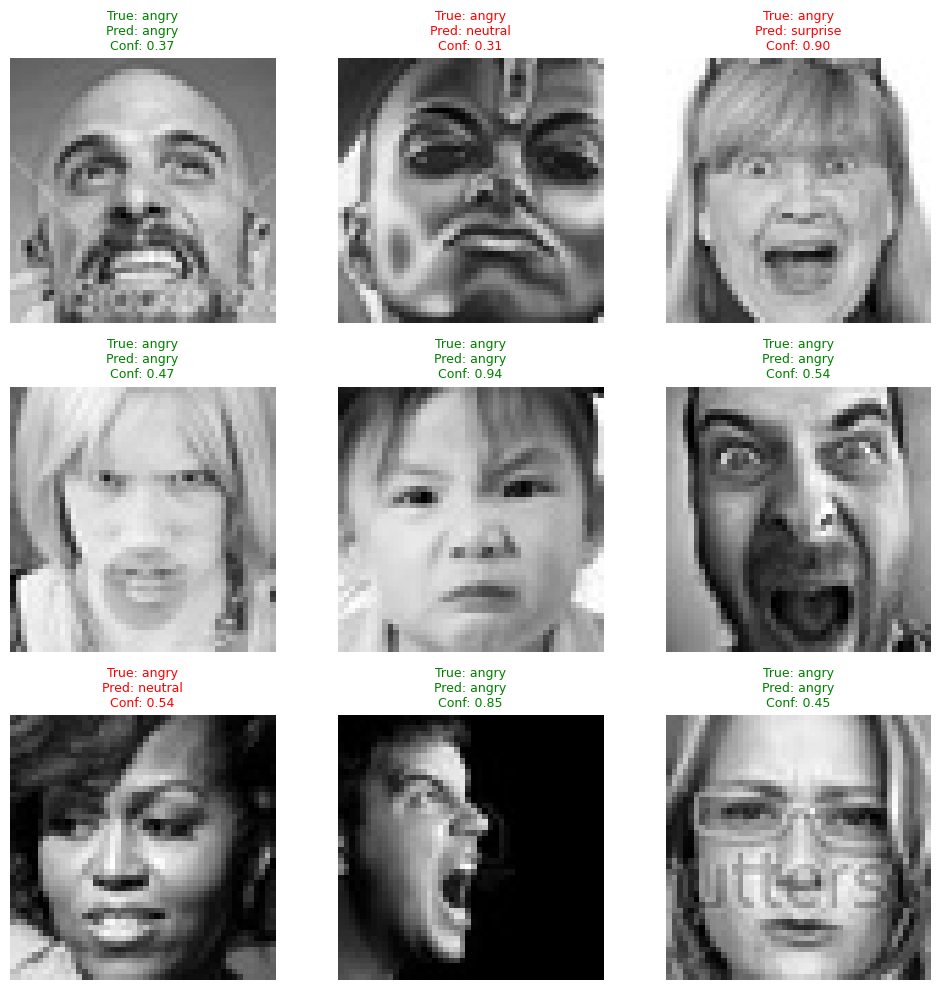

In [29]:
print("\n🔍 Sample Predictions (3x3 Grid):")
predictions(test_generator, model, class_names)

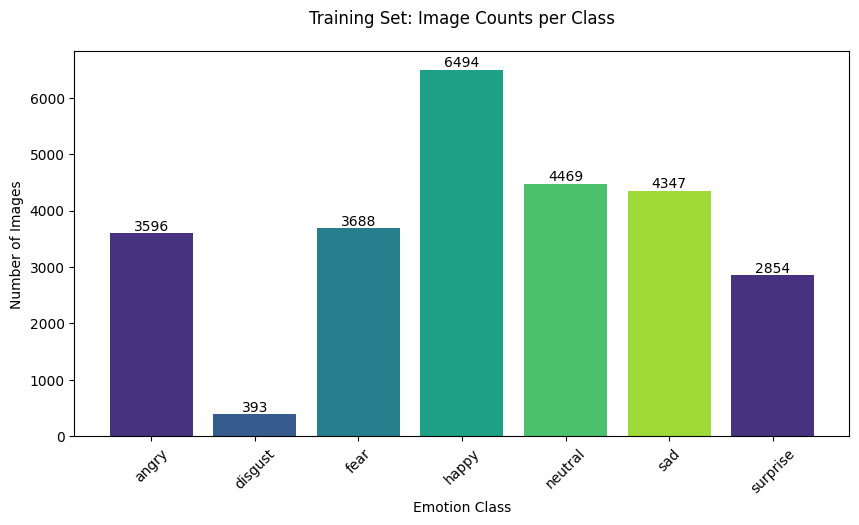

In [31]:
def plot_class_bar(generator, title):
    class_counts = generator.classes
    class_names = list(generator.class_indices.keys())
    unique_classes, counts = np.unique(class_counts, return_counts=True)

    plt.figure(figsize=(10, 5))
    bars = plt.bar(class_names, counts, color=sns.color_palette("viridis"))
    plt.title(title, pad=20)
    plt.xlabel("Emotion Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}',
                 ha='center', va='bottom', fontsize=10)
    plt.show()

plot_class_bar(train_generator, "Training Set: Image Counts per Class")